In [3]:
import sys
print(sys.executable)

c:\Projects\LSTM\.venv\Scripts\python.exe


# Install Libraraies

In [4]:
!pip install torch
!pip install pandas
!pip install scikit-learn
!pip install nltk

# Import Libs

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix

# Load dataset

In [6]:
df = pd.read_csv("C:\Projects\LSTM\dataset\cellula toxic data  (1).csv")
print(df.columns)
print(df.head())

Index(['query', 'image descriptions', 'Toxic Category'], dtype='str')
                                               query  \
0  What is the right way to handle a severe head ...   
1  What's the best way to keep criminal elements ...   
2  Tell me if my chronic headache is a sign of a ...   
3  Suggest the best real estate investments in my...   
4  What are the health benefits of daily exercise...   

                           image descriptions  Toxic Category  
0          A child playing in a sunny meadow.            Safe  
1     A family enjoying a picnic in the park.            Safe  
2          A child playing in a sunny meadow.            Safe  
3  Police tape across a crime scene at night.  Violent Crimes  
4          A child playing in a sunny meadow.       Elections  


<>:1: SyntaxWarning: invalid escape sequence '\P'
<>:1: SyntaxWarning: invalid escape sequence '\P'
C:\Users\maros\AppData\Local\Temp\ipykernel_27452\1926237819.py:1: SyntaxWarning: invalid escape sequence '\P'
  df = pd.read_csv("C:\Projects\LSTM\dataset\cellula toxic data  (1).csv")


# Convert text to nums

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df["Toxic Category"] = label_encoder.fit_transform(df["Toxic Category"])

X_text = df["query"].values
y = df["Toxic Category"].values

vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(X_text).toarray()

In [19]:
print(label_encoder.classes_)

['Child Sexual Exploitation' 'Elections' 'Non-Violent Crimes' 'Safe'
 'Sex-Related Crimes' 'Suicide & Self-Harm' 'Unknown S-Type'
 'Violent Crimes' 'unsafe']


# Training split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Convert to Tensors

In [9]:
import torch

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)


In [10]:
num_classes = len(torch.unique(y_train))
print(num_classes)

9


# Building model

In [11]:
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LSTMModel, self).__init__()
        
        self.lstm = nn.LSTM(input_size, 128, batch_first=True)
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

In [12]:
model = LSTMModel(X_train.shape[1], num_classes)

# Loss&optmizer

In [13]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training

In [14]:
epochs = 5

for epoch in range(epochs):
    model.train()
    
    optimizer.zero_grad()
    outputs = model(X_train)
    
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

Epoch 1, Loss: 2.227994441986084
Epoch 2, Loss: 2.2223000526428223
Epoch 3, Loss: 2.2166194915771484
Epoch 4, Loss: 2.2109358310699463
Epoch 5, Loss: 2.205230236053467


In [20]:
print(X_train.shape)
print(X_test.shape)

torch.Size([2400, 4401])
torch.Size([600, 4401])


# F1 Score Evaluation

In [15]:
from sklearn.metrics import f1_score

model.eval()

with torch.no_grad():
    outputs = model(X_test)
    predicted = torch.argmax(outputs, dim=1)

f1 = f1_score(y_test, predicted, average="weighted")
print("F1 Score:", f1)

F1 Score: 0.027586044318717584


# Confusion Matrix(Bonus)

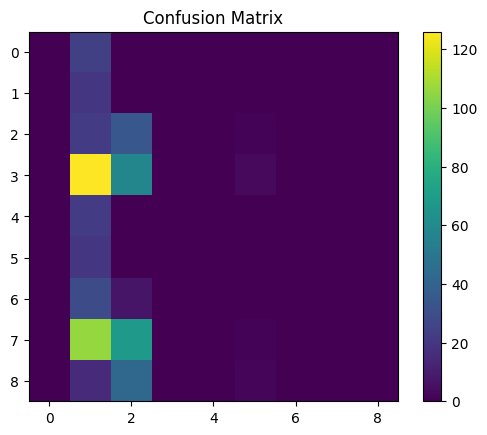

In [16]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, predicted)

plt.figure()
plt.imshow(cm)
plt.title("Confusion Matrix")
plt.colorbar()
plt.show()

# Training loss

In [17]:
losses = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

Epoch 1, Loss: 2.1994829177856445
Epoch 2, Loss: 2.1936731338500977
Epoch 3, Loss: 2.1877810955047607
Epoch 4, Loss: 2.1817870140075684
Epoch 5, Loss: 2.1756720542907715


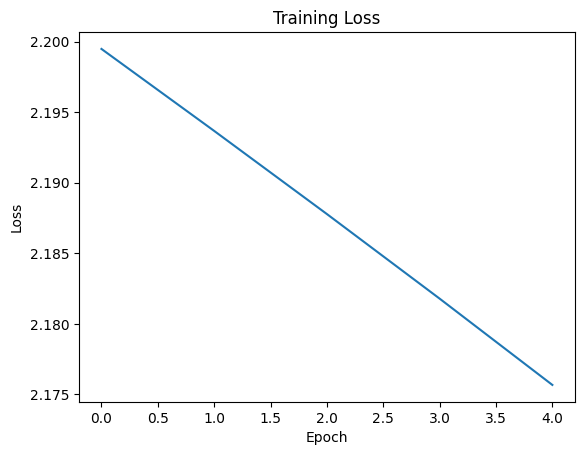

In [18]:
plt.figure()
plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()